## MTH9894 Algo Trading: Pairs Trading in the U.S. Equities Market
## Team04: Mengyu Zhang, Xinlu Xiao, Deyun Li
### Reference: Statistical Arbitrage in U.S. Equities Market
### Authors: Marco Avellaneda, Jeong-Hyun Lee
---

### <font color=Blue> Documentation</font>
#### More explanations could be found in the documents for each function

-Data Process

* In this part, we define the functin data_process. It mainly extract the data we need. It has two parameters, start and period. Start is the date we start to trade. Period is the length of one trading window. Function data_process extract historical return ,price, bid,ask,company name data from the raw data. Pass these data to function find_pair to do procedding processing

-Find pairs

* In this part, we define three functions, find_pair,filter_pair,cointegration_test. Function find_pair takes three parameters, start,period,num. Start and period is means the same with that in data_process, num is the number of pairs we find in each trading window. After extract necessary data using data_process. Find_pair do principal component analysis and extract the data information for stocks picked. Pass the data to function cointegration_test to find the pvalue of every stock pair. Then use function filter_pair to select num pairs of cointegrated stock pairs. 

-Strategy:

* generate_signal: Find the trading signal in one window

* build_position : Build the position for updating position of pairs and cash value

-Backtest

* backtest: Backtest pair trading algorithm 

* Plot_result: Plot result from backtesting: sp500 accumulative return and pair trading return, sharp ratio, maximum drawdown

#### To run the code, run the "back_test" function we have built, and you will see the graph and ratios

In [72]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from math import *
from datetime import datetime
from datetime import timedelta
import statsmodels.tsa.stattools as stat
import seaborn as sns

# import py file
%run strategy.py   # strategy.py
%run find_pairs.py
%run plot_result.py

%matplotlib inline

In [73]:
def backtest(start_date, end_date, pair_num):
    '''Backtest pair trading algorithm 
    Parameters
    ---------------------
    start_date:      int, start time of the trading period
    end_date:        int, end time of the trading period
    pair_num:        int, number of pairs chosen for one trading window (60 days)
    date_in_data:    list, a list for storing dates for the whole trading data
    pair_start_date: int, start time for the pair searching time frame
    pair_end_date:   int, end time for the pair searching time frame
    
    Return
    ---------------------
    cash_value_list:      list, cash positions of the trading period
    portfolio_value_list: list, portfolio value of the trading period
    sp500_index:          Series, sp500 index of the trading period 
    rf_rate_start:        float, risk free rate of the trading period
    
    '''
    with open ('sp_500_daily_return.csv') as return_data:
        global_sp_ret = pd.read_csv(return_data,engine='c')
        date_in_data=list(global_sp_ret.ix[:,0])
    
    # load datafiles
    with open ('SP500TR.csv') as return_data:
        sp500_index = pd.read_csv(return_data,engine='c')
        sp500_index = sp500_index[['Date','Adj Close']]

    with open ('TNX.csv') as return_data:
        rf_rate = pd.read_csv(return_data,engine='c')
    
    rf_rate = rf_rate[['Date','Adj Close']]
    
    # Set moving window length
    win_len = 60
    
    # Find index for start_date, end_date in date_in_data
    start_date_index  = date_in_data.index(start_date)
    end_date_index = date_in_data.index(end_date)
   
    # Calculate number of windows in trading period
    win_num = int((end_date_index - start_date_index + 1)/win_len)
    
    # Get start date for pair searching
    pair_start_date = date_in_data[start_date_index -win_len * 9]
    
    # Get sp500 index data from start_date to end_date
    print('start_date')
    date_str = date_int_to_string(start_date)
    sp500_start_index = sp500_index[sp500_index['Date'] == date_str].index.tolist()[0]
    sp500_index = sp500_index['Adj Close'][sp500_start_index : sp500_start_index + end_date_index - start_date_index + 1]
    
    rf_rate_start = 0.03
    
    # Set initial cash position
    cash = 50000
    cash_value_list = []
    
    # Find pairs, build position, update cash, portfolio value list with 60 days rolling window
    for i in range(win_num):
        print("start: ", pair_start_date)
        data, pairs = find_pair(pair_start_date, win_len, pair_num)
        cash, cash_value = build_position(cash, pairs, data, win_len, -1.5,-0.4,0.4,1.5)
        cash_value_list += list(cash_value)
        start_date_index += win_len
        pair_start_date = date_in_data[start_date_index - win_len * 9]
        print(cash)
    
    
    last_win_len = (end_date_index - start_date_index + 1) % win_len
    print("last_win_len ", last_win_len)
    print("start: ", pair_start_date)
    data, pairs = find_pair(pair_start_date, last_win_len, pair_num)
    cash, cash_value = build_position(cash, pairs, data, last_win_len, -1.5,-0.4,0.4,1.5)
    cash_value_list += list(cash_value)
    print(cash)
    
    return cash_value_list, sp500_index, rf_rate_start
      

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (13,17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2821: DtypeWarning: Columns (13,17) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


start_date
start:  19990927


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: DtypeWarning: Columns (13,17) have mixed types. Specify dtype option on import or set low_memory=False.


39877.906
start:  19991221
49535.4715
start:  20000317
59217.2455
start:  20000613
75551.253
start:  20000907
78774.066
start:  20001201
87041.4715
start:  20010301
99471.209
start:  20010525
83120.149
start:  20010821
79958.852
start:  20011120
63650.557
start:  20020219
79439.525
start:  20020515
82682.345
start:  20020809
85635.381
start:  20021104
106125.573
start:  20030131
125871.299
start:  20030429
125383.478
start:  20030724
148977.895
start:  20031017
171077.651
last_win_len  21
start:  20040114
194131.174


C:\Users\JYJ\Downloads\MTH9894-Algo-Trading-master (1)\MTH9894-Algo-Trading-master\project\plot_result.py:37: FutureWarning: pd.expanding_max is deprecated for ndarrays and will be removed in a future version
  tmp *= (1 + sp500_ret[i])


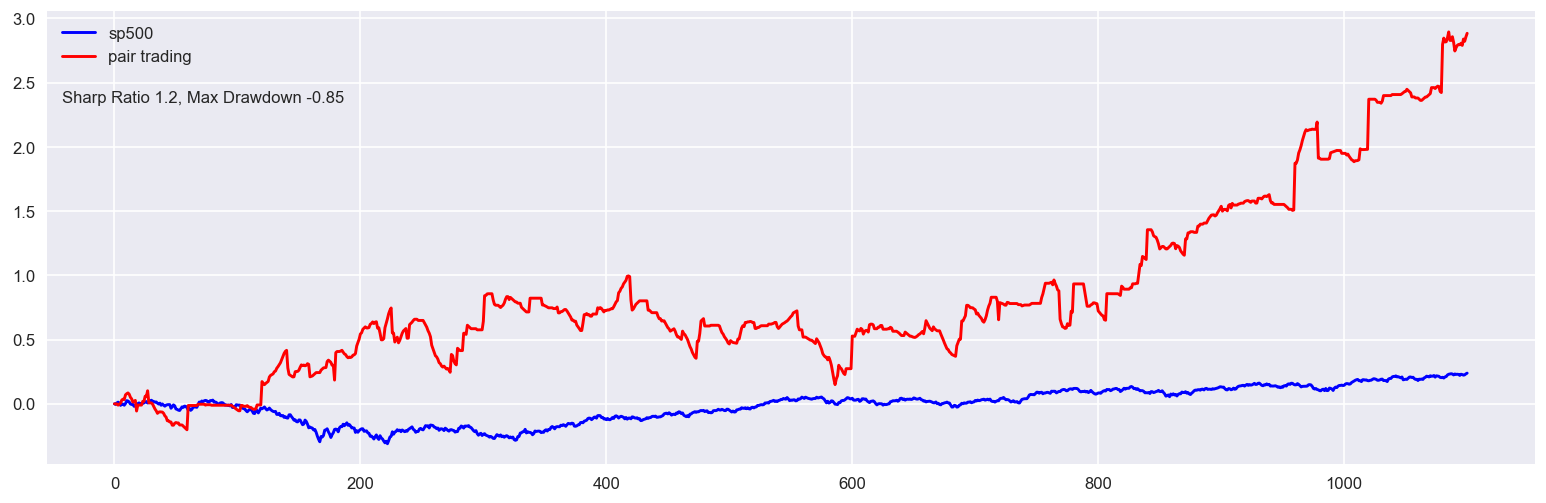

In [74]:
if __name__ == '__main__':
    with open ('sp_500_daily_return.csv') as return_data:
        global_sp_ret = pd.read_csv(return_data,engine='c')
        date_in_data=list(global_sp_ret.ix[:,0])
    #result = backtest(date_in_data[3540], date_in_data[4640], 10)
    #result = backtest(date_in_data[3540], date_in_data[3580], 10)
    result = backtest(date_in_data[3000], date_in_data[4100], 10)
    plot_result(result)